<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/gaig-layout-lm-v3/part_3_gaig_fine_tuning_layoutlmv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

**Reference**:

https://medium.com/@shivarama/layoutlmv3-from-zero-to-hero-part-3-16ae58291e9d

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install accelerate -U

In [3]:
import torch
import numpy as np
import pandas as pd

from  PIL import Image
from PIL import ImageDraw, ImageFont

from datasets import load_dataset
from datasets.features import ClassLabel
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from datasets import load_metric

from transformers import AutoProcessor
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator
from transformers import AutoModelForTokenClassification

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
!unzip dataset_layoutlm_v3.zip

Archive:  dataset_layoutlm_v3.zip
  inflating: dataset_layoutlm_v3/098d15d0-gaig_page_0.png  
  inflating: dataset_layoutlm_v3/0dab5ca9-page_3.png  
  inflating: dataset_layoutlm_v3/11a42e15-page_4.png  
  inflating: dataset_layoutlm_v3/1844182e-page_0.png  
  inflating: dataset_layoutlm_v3/1d13aa17-page_6.png  
  inflating: dataset_layoutlm_v3/20aa45bc-page_0.png  
  inflating: dataset_layoutlm_v3/221aa10e-page_6.png  
  inflating: dataset_layoutlm_v3/2b0dd6dc-page_0.png  
  inflating: dataset_layoutlm_v3/36153bbd-page_1.png  
  inflating: dataset_layoutlm_v3/42bc6dc6-page_7.png  
  inflating: dataset_layoutlm_v3/487f51f1-page_1.png  
  inflating: dataset_layoutlm_v3/55c9c7ed-page_1.png  
  inflating: dataset_layoutlm_v3/5ad1983f-page_0.png  
  inflating: dataset_layoutlm_v3/5e4ad096-page_0.png  
  inflating: dataset_layoutlm_v3/6052e488-page_0.png  
  inflating: dataset_layoutlm_v3/62a0a0c5-page_4.png  
  inflating: dataset_layoutlm_v3/63b41cd8-page_4.png  
  inflating: dataset_layou

## Load dataset

In [6]:
# this dataset uses the new Image feature :)
dataset = load_dataset("./dataset_layoutlm_v3.py", trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

{'id': 2, 'file_name': 'dc03d74d-page_1.png', 'tokens': ['73,962,999.00', '4-28-2023', '4-28-24'], 'bboxes': [[1127, 1829, 1342, 1865], [429, 834, 583, 865], [889, 830, 1034, 881]], 'ner_tags': [15, 10, 11]}
{'id': 23, 'file_name': '73cbce30-page_0.png', 'tokens': ['_Mega', 'Lab-Health', 'Care', 'Svc,', 'LLC', '2296', 'Opitz', 'Blvd,', 'Suite', '260', 'Woodbridge', '_', '22191', '05/27/2012', 'www.megalabservices.com', 'Medical', 'Laboratory', '850,000.00', '850,000.00', '450,000.00', '450,000.00', '1,200,000.00', '1,200,000.00'], 'bboxes': [[391, 1358, 459, 1381], [469, 1359, 605, 1380], [616, 1360, 675, 1380], [685, 1360, 730, 1381], [748, 1360, 798, 1381], [494, 1436, 556, 1456], [567, 1436, 632, 1461], [641, 1436, 700, 1460], [711, 1437, 774, 1457], [783, 1437, 828, 1458], [305, 1513, 494, 1541], [472, 1504, 495, 1558], [2023, 1520, 2097, 1542], [1038, 1594, 1183, 1622], [1624, 1599, 1966, 1622], [628, 1933, 723, 1955], [733, 1934, 867, 1960], [1369, 2727, 1510, 2753], [821, 2597, 

Generating test split: 0 examples [00:00, ? examples/s]

{'id': 7, 'file_name': 'a899f615-page_0.png', 'tokens': ['Dynamic', 'Engineering', 'Consultants', 'PC', 'Main', 'Street', 'Lake', 'Como', 'New', 'Jersey', '07719', 'Land', 'Development', 'Www.dynamicec.com', '04/01/2004', '$', '_51', 'milloin'], 'bboxes': [[449, 611, 586, 645], [600, 611, 787, 645], [801, 610, 989, 638], [1004, 610, 1049, 638], [615, 681, 677, 704], [689, 680, 768, 704], [259, 746, 326, 771], [338, 746, 422, 771], [282, 813, 342, 837], [352, 813, 443, 843], [1318, 811, 1413, 837], [700, 879, 768, 904], [782, 879, 971, 910], [454, 1076, 780, 1110], [678, 948, 845, 974], [633, 1217, 648, 1245], [681, 1209, 709, 1234], [728, 1209, 816, 1234]], 'ner_tags': [0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 8, 8, 5, 7, 15, 15, 15]}
{'id': 42, 'file_name': '5e4ad096-page_0.png', 'tokens': ['Gabriel', 'Roeder', 'Smith', '&', 'Company', 'Holdings', 'and', 'all', 'subsidiaries', 'One', 'Towne', 'Square', 'Suite', '800', 'Southfield,', 'MI', '48076', 'www.arsconsulting.com', '1962', 'Actuarial',

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 41
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 5
    })
})

In [8]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['APPLICANT_NAME', 'APPLICANT_ADDRESS', 'APPLICANT_CITY', 'APPLICANT_STATE', 'APPLICANT_ZIP', 'APPLICANT_WEBSITE_1', 'APPLICANT_WEBSITE_2', 'EST_DATE', 'NATURE_BUSINESS_BLANK_DESC', 'APPLICANT_COUNTRY', 'EFFECTIVE_DATE', 'EXPIRATION_DATE', 'REVENUE_CURRENT_YEAR', 'REVENUE_CURRENT_YEAR_DOMESTIC', 'REVENUE_CURRENT_YEAR_FOREIGN', 'REVENUE_PRIOR_YEAR', 'REVENUE_PRIOR_YEAR_DOMESTIC', 'REVENUE_PRIOR_YEAR_FOREIGN', 'REVENUE_NEXT_YEAR', 'REVENUE_NEXT_YEAR_DOMESTIC', 'REVENUE_NEXT_YEAR_FOREIGN'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

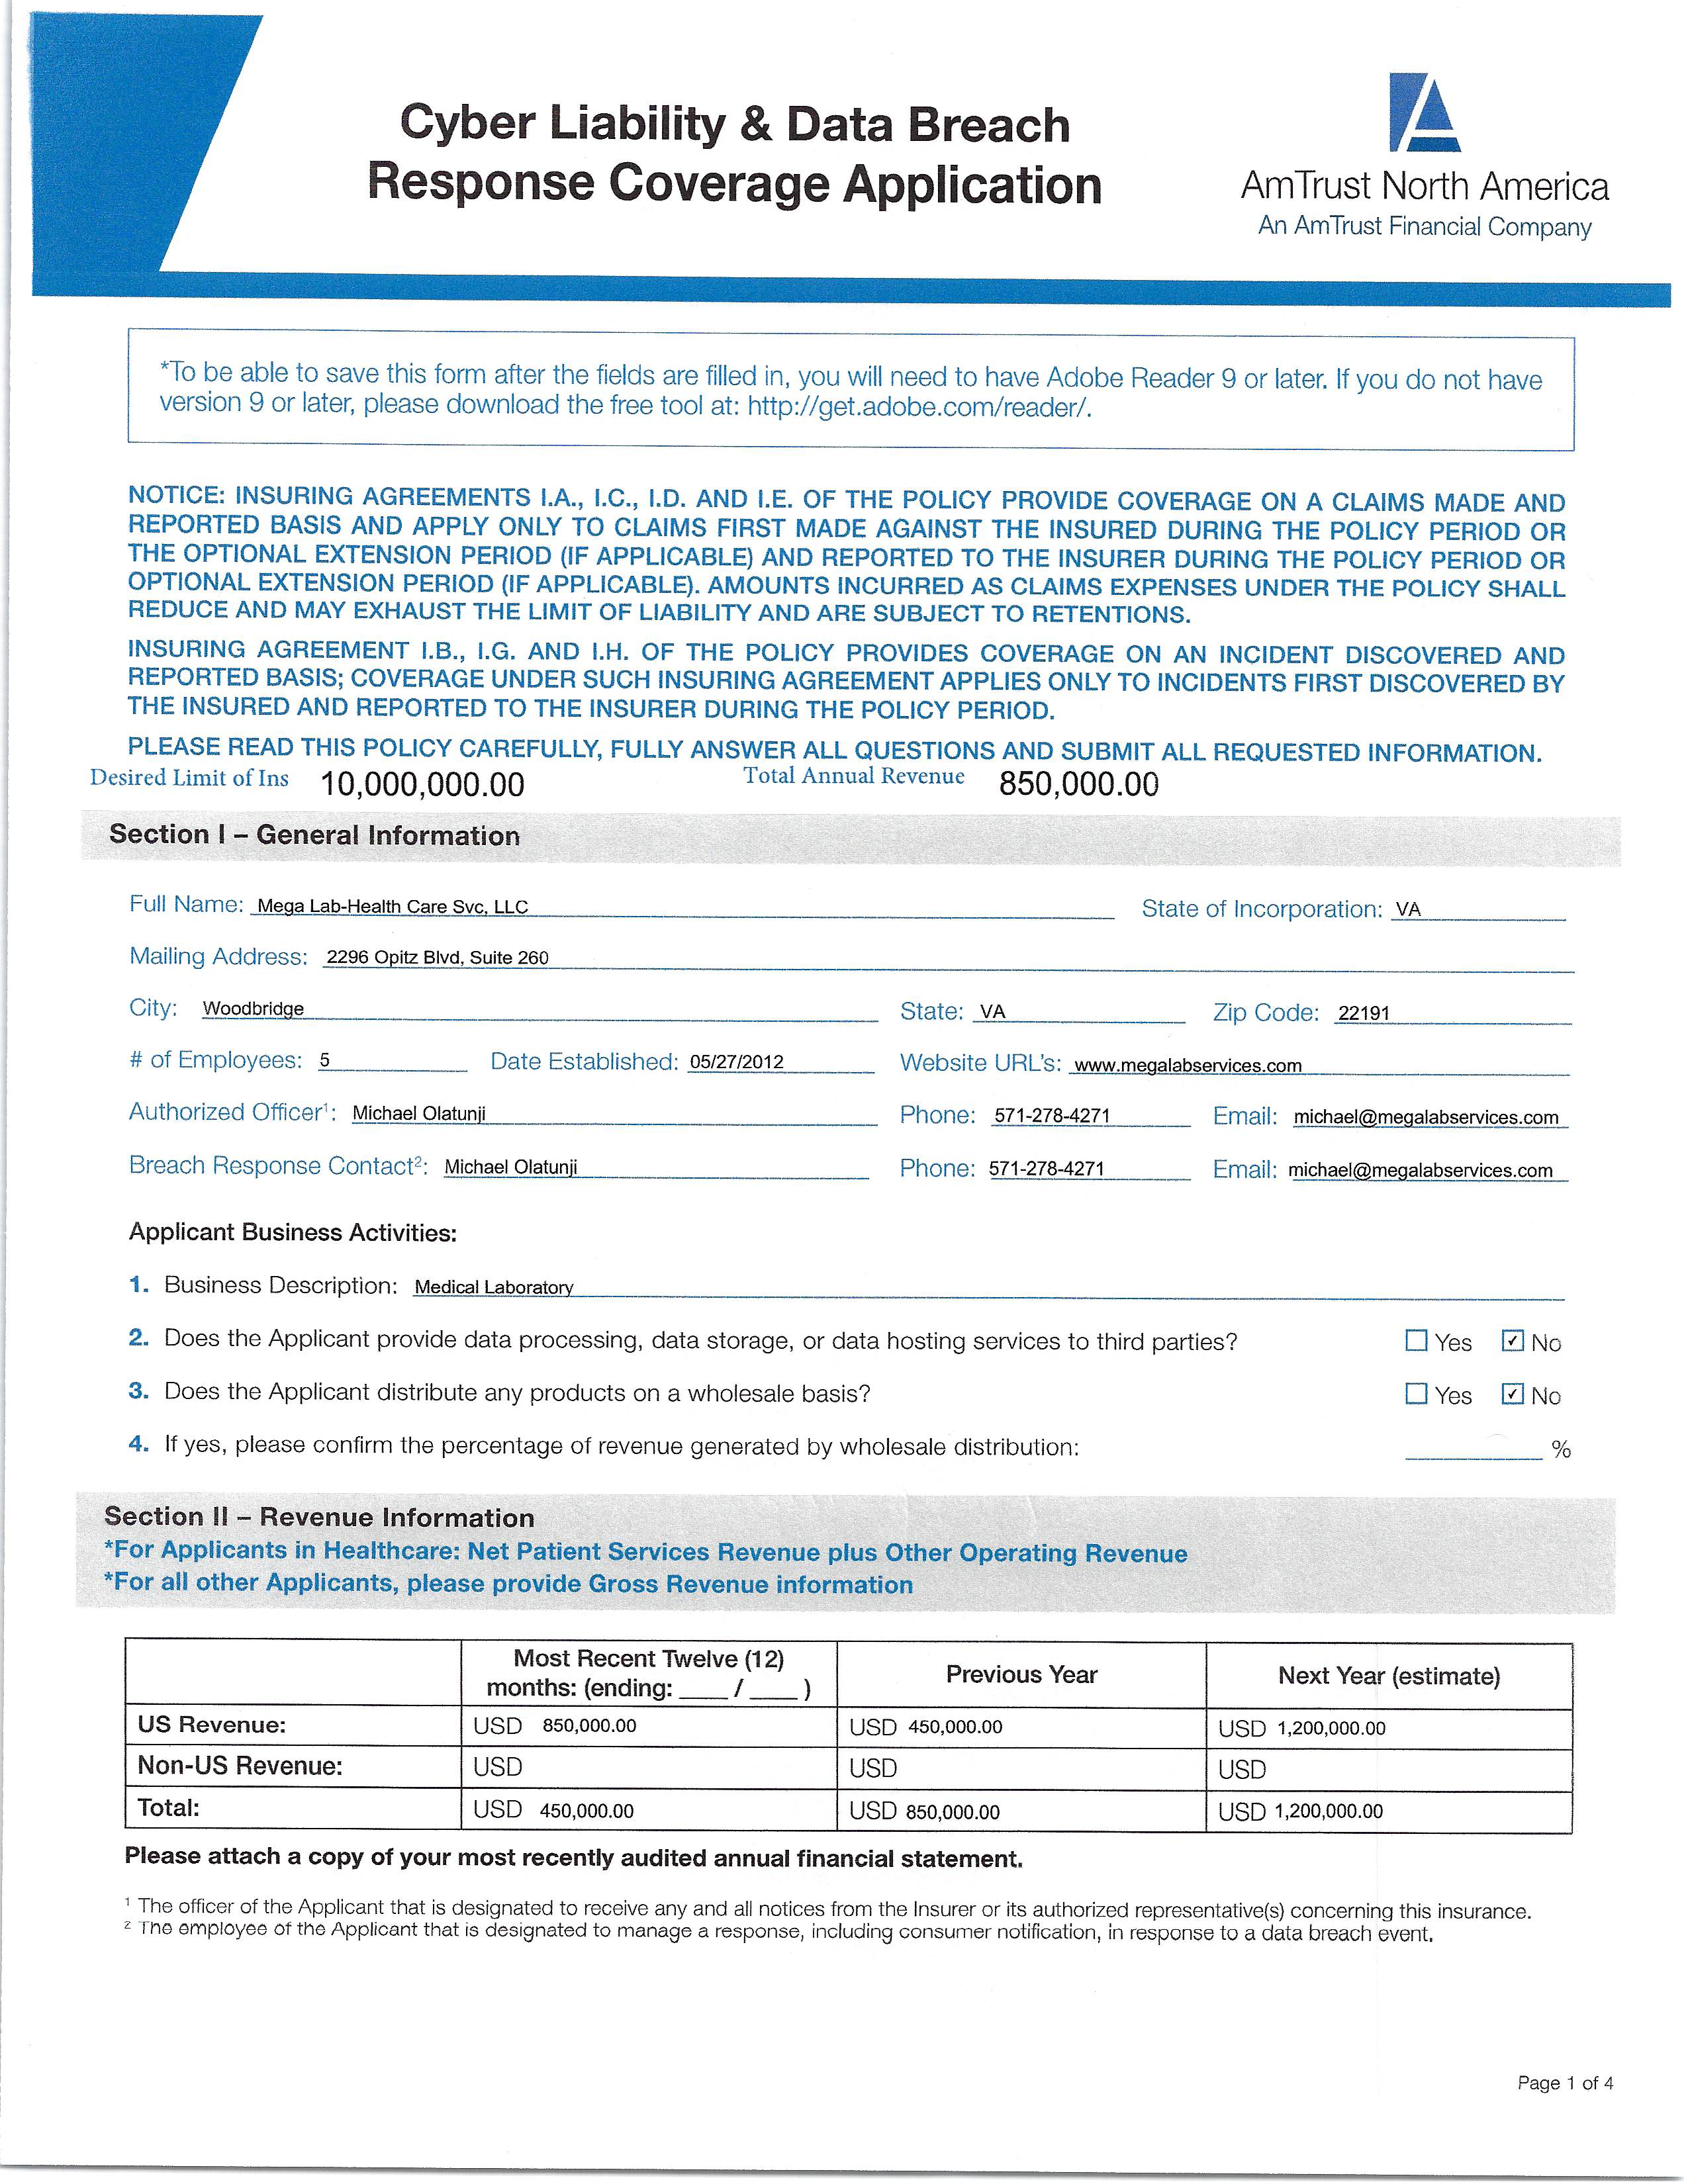

In [10]:
# Inspect one of the annotated images
example = dataset["train"][1]
example["image"]

In [11]:
sample_img = example["image"].convert("RGB")
sample_img.size

(2550, 3300)

In [13]:
sample_img = Image.open(r"/content/dataset_layoutlm_v3/0dab5ca9-page_3.png").convert("RGB")
sample_img.size

(2550, 3300)

In [14]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['_Mega', 'Lab-Health', 'Care', 'Svc,', 'LLC', '2296', 'Opitz', 'Blvd,', 'Suite', '260', 'Woodbridge', '_', '22191', '05/27/2012', 'www.megalabservices.com', 'Medical', 'Laboratory', '850,000.00', '850,000.00', '450,000.00', '450,000.00', '1,200,000.00', '1,200,000.00']
[[153, 411, 180, 418], [183, 411, 237, 418], [241, 412, 264, 418], [268, 412, 286, 418], [293, 412, 312, 418], [193, 435, 218, 441], [222, 435, 247, 442], [251, 435, 274, 442], [278, 435, 303, 441], [307, 435, 324, 441], [119, 458, 193, 466], [185, 455, 194, 472], [793, 460, 822, 467], [407, 483, 463, 491], [636, 484, 770, 491], [246, 585, 283, 592], [287, 586, 340, 593], [536, 826, 592, 834], [321, 786, 376, 793], [538, 787, 593, 794], [320, 825, 375, 833], [755, 825, 819, 833], [757, 787, 820, 795]]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 4, 7, 5, 8, 8, 15, 16, 12, 13, 18, 19]


## Load Tokenizer

In [ ]:
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [16]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

In [17]:
# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label

In [18]:
if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [19]:
print(label_list)

['APPLICANT_NAME', 'APPLICANT_ADDRESS', 'APPLICANT_CITY', 'APPLICANT_STATE', 'APPLICANT_ZIP', 'APPLICANT_WEBSITE_1', 'APPLICANT_WEBSITE_2', 'EST_DATE', 'NATURE_BUSINESS_BLANK_DESC', 'APPLICANT_COUNTRY', 'EFFECTIVE_DATE', 'EXPIRATION_DATE', 'REVENUE_CURRENT_YEAR', 'REVENUE_CURRENT_YEAR_DOMESTIC', 'REVENUE_CURRENT_YEAR_FOREIGN', 'REVENUE_PRIOR_YEAR', 'REVENUE_PRIOR_YEAR_DOMESTIC', 'REVENUE_PRIOR_YEAR_FOREIGN', 'REVENUE_NEXT_YEAR', 'REVENUE_NEXT_YEAR_DOMESTIC', 'REVENUE_NEXT_YEAR_FOREIGN']


In [20]:
print(id2label)

{0: 'APPLICANT_NAME', 1: 'APPLICANT_ADDRESS', 2: 'APPLICANT_CITY', 3: 'APPLICANT_STATE', 4: 'APPLICANT_ZIP', 5: 'APPLICANT_WEBSITE_1', 6: 'APPLICANT_WEBSITE_2', 7: 'EST_DATE', 8: 'NATURE_BUSINESS_BLANK_DESC', 9: 'APPLICANT_COUNTRY', 10: 'EFFECTIVE_DATE', 11: 'EXPIRATION_DATE', 12: 'REVENUE_CURRENT_YEAR', 13: 'REVENUE_CURRENT_YEAR_DOMESTIC', 14: 'REVENUE_CURRENT_YEAR_FOREIGN', 15: 'REVENUE_PRIOR_YEAR', 16: 'REVENUE_PRIOR_YEAR_DOMESTIC', 17: 'REVENUE_PRIOR_YEAR_FOREIGN', 18: 'REVENUE_NEXT_YEAR', 19: 'REVENUE_NEXT_YEAR_DOMESTIC', 20: 'REVENUE_NEXT_YEAR_FOREIGN'}


## Tokenize dataset

In [21]:
def prepare_example(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]

    encoding = processor(
        images, words, boxes=boxes, word_labels=word_labels,
        padding="max_length",
        truncation=True
    )
    return encoding

In [22]:
# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_example,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_example,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [23]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 41
})

In [24]:
example = train_dataset[0]
processor.tokenizer.decode(example['input_ids'])

'<s> 73,962,999.00 4-28-2023 4-28-24</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [25]:
train_dataset.set_format("torch")

In [26]:
example = train_dataset[0]
for k, v in example.items():
  print(f"{k}\t >> {v.shape}")

pixel_values	 >> torch.Size([3, 224, 224])
input_ids	 >> torch.Size([512])
attention_mask	 >> torch.Size([512])
bbox	 >> torch.Size([512, 4])
labels	 >> torch.Size([512])


In [27]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 5
})

In [28]:
processor.tokenizer.decode(eval_dataset[0]['input_ids'])

'<s> Dynamic Engineering Consultants PC Main Street Lake Como New Jersey 07719 Land Development Www.dynamicec.com 04/01/2004 $ _51 milloin</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

## Load Model

In [ ]:
metric = load_metric("seqeval")

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [31]:
training_args = TrainingArguments(
    output_dir="./test",
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [32]:
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [33]:
trainer.train()

TrainOutput(global_step=1000, training_loss=0.4184000053405762, metrics={'train_runtime': 418.7493, 'train_samples_per_second': 4.776, 'train_steps_per_second': 2.388, 'total_flos': 518429152410624.0, 'train_loss': 0.4184000053405762, 'epoch': 47.61904761904762})

In [34]:
trainer.evaluate()

{'eval_loss': 0.3495646119117737,
 'eval_precision': 0.8064516129032258,
 'eval_recall': 0.8333333333333334,
 'eval_f1': 0.819672131147541,
 'eval_accuracy': 0.8888888888888888,
 'eval_runtime': 0.562,
 'eval_samples_per_second': 8.897,
 'eval_steps_per_second': 5.338,
 'epoch': 47.61904761904762}

## Inferencing

In [35]:
model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

In [36]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'])


In [37]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 38])
attention_mask torch.Size([1, 38])
bbox torch.Size([1, 38, 4])
labels torch.Size([1, 38])
pixel_values torch.Size([1, 3, 224, 224])


In [38]:
with torch.no_grad():
  outputs = model(**encoding)

In [39]:
logits = outputs.logits
logits.shape

torch.Size([1, 38, 21])

In [40]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[3, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3]


In [41]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 0, 0, 0, -100, 0, 1, 1, 2, 2, -100, 3, 3, 4, -100, -100, 8, 8, 5, -100, -100, -100, -100, -100, -100, -100, -100, 7, -100, -100, -100, -100, 15, 15, -100, 15, -100, -100]


In [42]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [47]:
true_predictions

['APPLICANT_NAME',
 'APPLICANT_NAME',
 'APPLICANT_NAME',
 'APPLICANT_NAME',
 'APPLICANT_ADDRESS',
 'APPLICANT_ADDRESS',
 'APPLICANT_CITY',
 'APPLICANT_CITY',
 'APPLICANT_CITY',
 'APPLICANT_CITY',
 'APPLICANT_ZIP',
 'NATURE_BUSINESS_BLANK_DESC',
 'NATURE_BUSINESS_BLANK_DESC',
 'APPLICANT_WEBSITE_1',
 'EST_DATE',
 'EST_DATE',
 'EST_DATE',
 'EST_DATE']

In [48]:
true_labels

['APPLICANT_NAME',
 'APPLICANT_NAME',
 'APPLICANT_NAME',
 'APPLICANT_NAME',
 'APPLICANT_ADDRESS',
 'APPLICANT_ADDRESS',
 'APPLICANT_CITY',
 'APPLICANT_CITY',
 'APPLICANT_STATE',
 'APPLICANT_STATE',
 'APPLICANT_ZIP',
 'NATURE_BUSINESS_BLANK_DESC',
 'NATURE_BUSINESS_BLANK_DESC',
 'APPLICANT_WEBSITE_1',
 'EST_DATE',
 'REVENUE_PRIOR_YEAR',
 'REVENUE_PRIOR_YEAR',
 'REVENUE_PRIOR_YEAR']

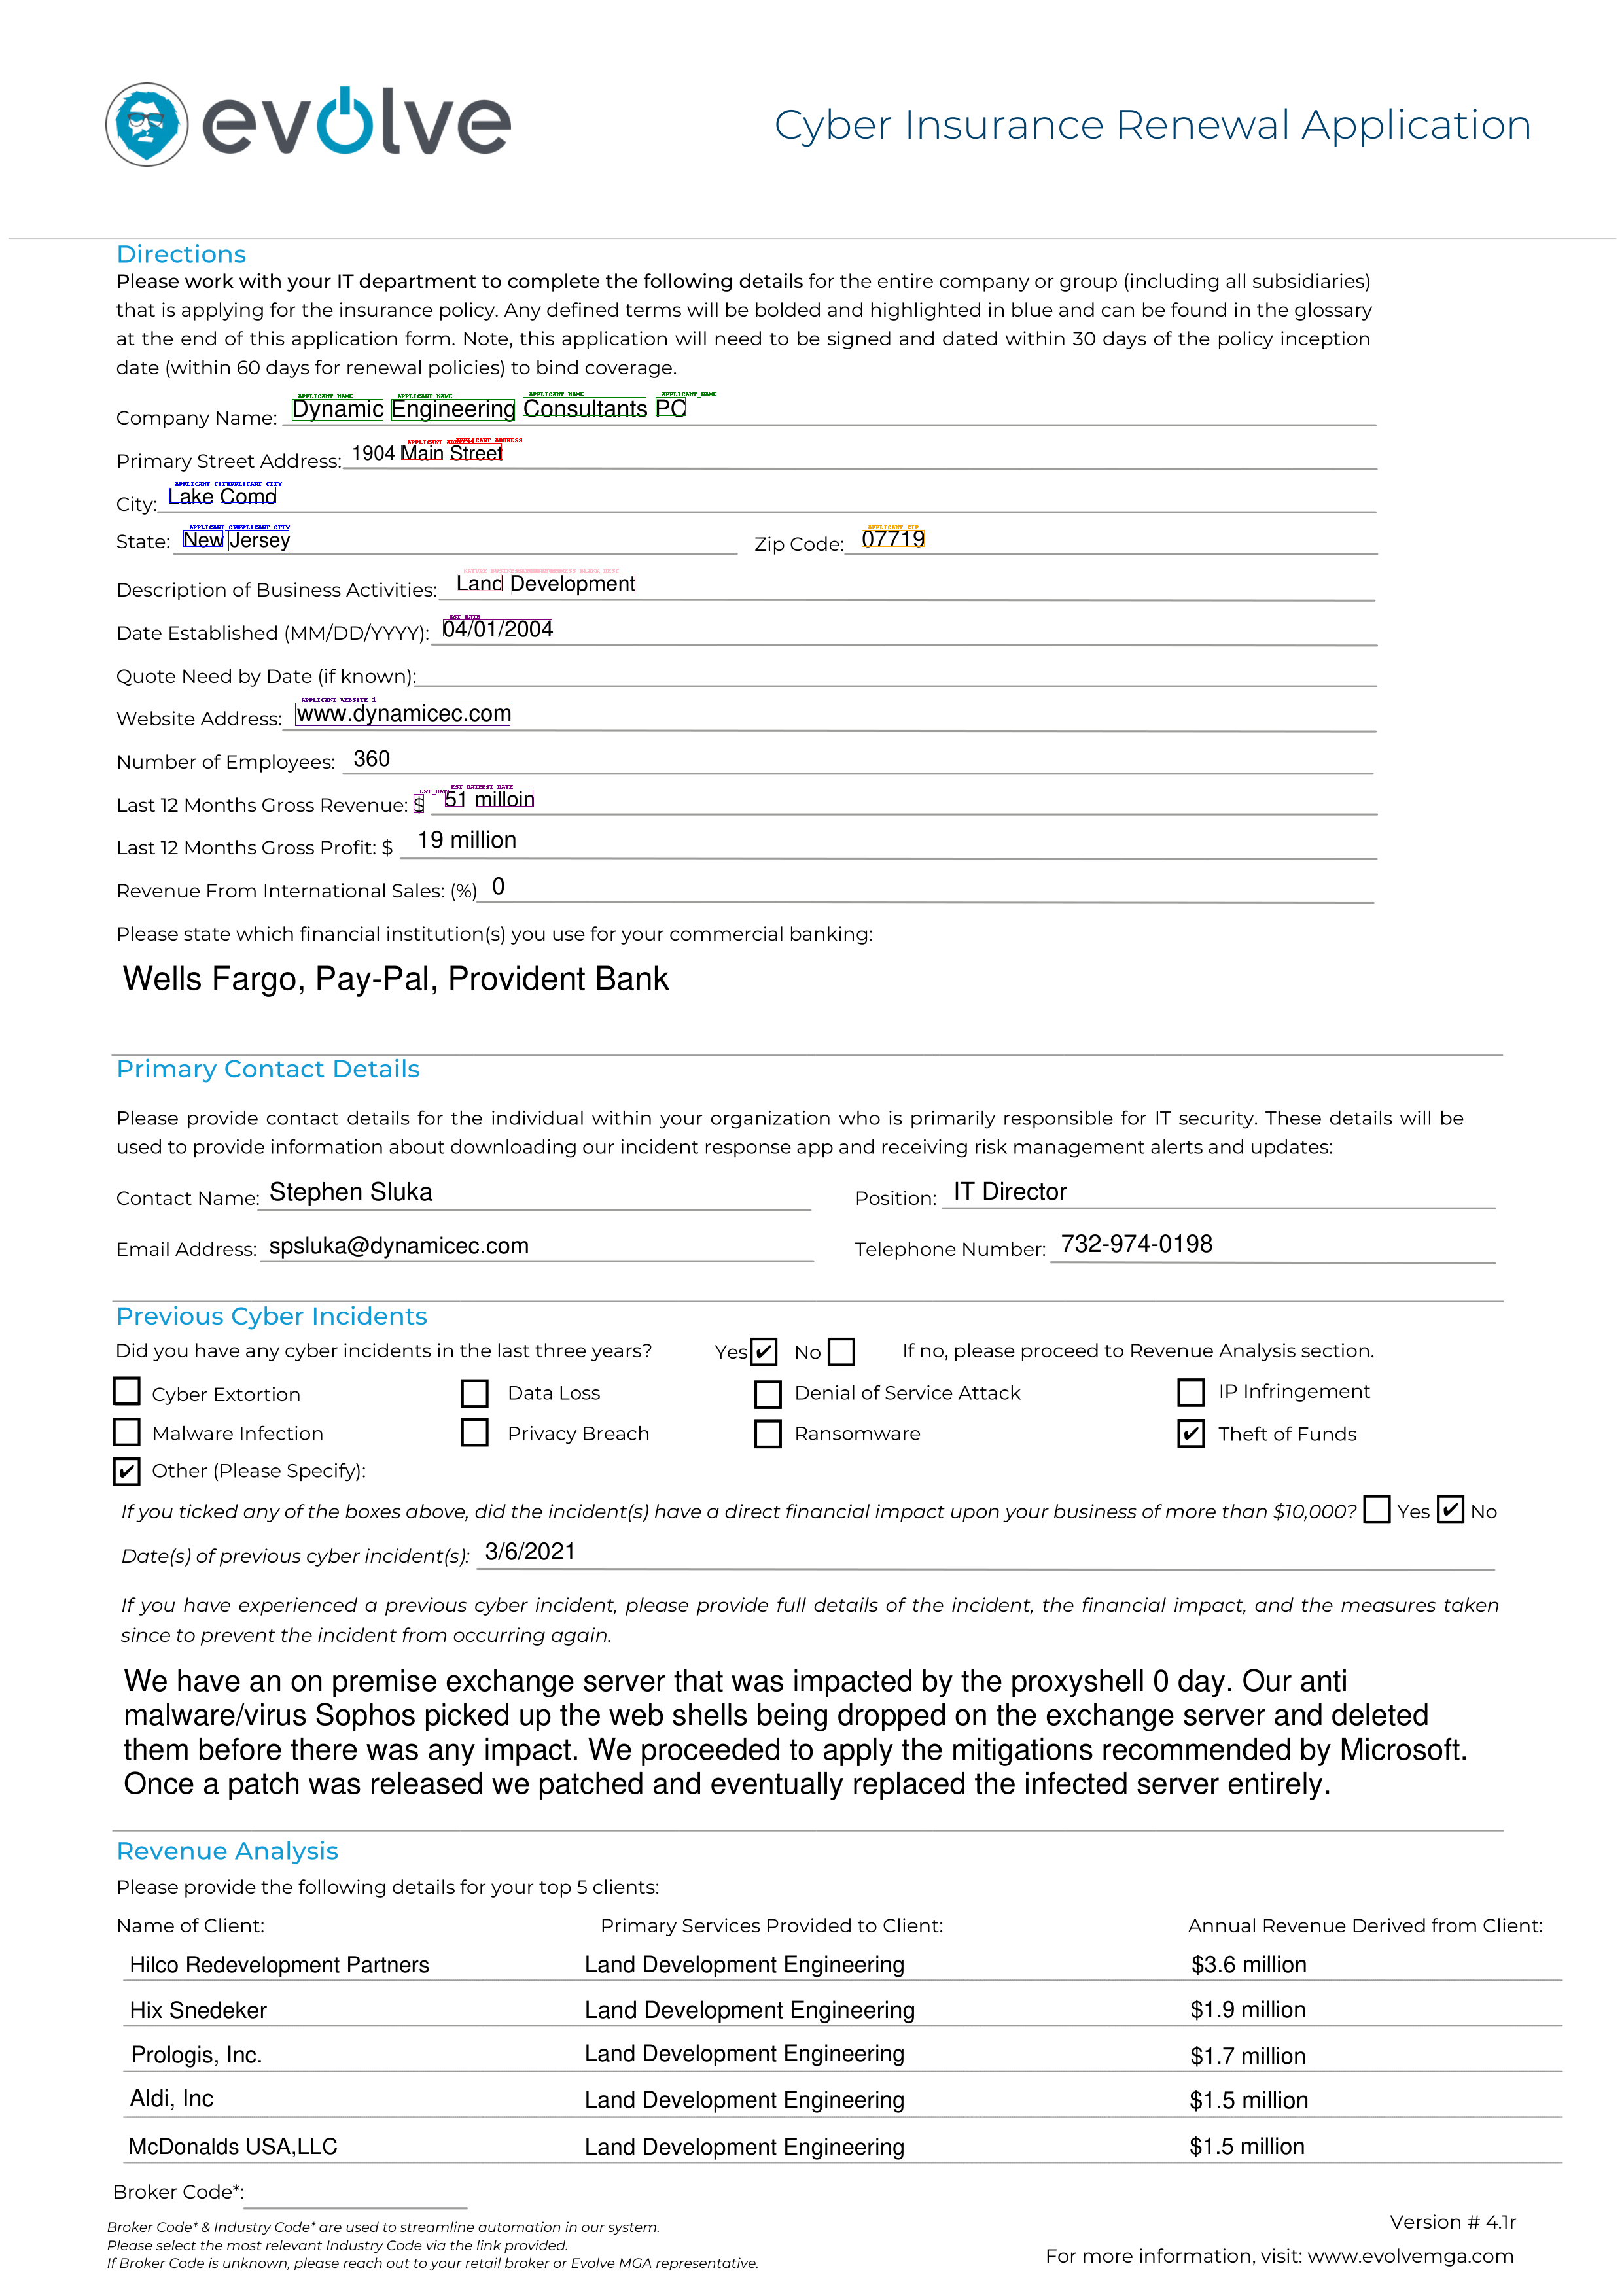

In [44]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {
	"APPLICANT_NAME": "green",
	"APPLICANT_ADDRESS": "red",
	"APPLICANT_CITY": "blue",
	"APPLICANT_STATE": "yellow",
	"APPLICANT_ZIP": "orange",
	"APPLICANT_WEBSITE_1": "indigo",
	"APPLICANT_WEBSITE_2": "violet",
	"EST_DATE": "purple",
	"NATURE_BUSINESS_BLANK_DESC": "pink",
	"APPLICANT_COUNTRY": "olive",
	"EFFECTIVE_DATE": "maroon",
	"EXPIRATION_DATE": "teal",
	"REVENUE_CURRENT_YEAR": "burgundy",
	"REVENUE_CURRENT_YEAR_DOMESTIC": "mauve",
	"REVENUE_CURRENT_YEAR_FOREIGN": "rust",
	"REVENUE_PRIOR_YEAR": "cyan",
	"REVENUE_PRIOR_YEAR_DOMESTIC": "bronze",
	"REVENUE_PRIOR_YEAR_FOREIGN": "navy",
	"REVENUE_NEXT_YEAR": "khaki",
	"REVENUE_NEXT_YEAR_DOMESTIC": "cobalt",
	"REVENUE_NEXT_YEAR_FOREIGN": "emerald"
}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

APPLICANT_NAME: Dynamic
APPLICANT_NAME: Engineering
APPLICANT_NAME: Consultants
APPLICANT_NAME: PC
APPLICANT_ADDRESS: Main
APPLICANT_ADDRESS: Street
APPLICANT_CITY: Lake
APPLICANT_CITY: Como
APPLICANT_STATE: New
APPLICANT_STATE: Jersey
APPLICANT_ZIP: 07719
NATURE_BUSINESS_BLANK_DESC: Land
NATURE_BUSINESS_BLANK_DESC: Development
APPLICANT_WEBSITE_1: Www.dynamicec.com
EST_DATE: 04/01/2004
REVENUE_PRIOR_YEAR: $
REVENUE_PRIOR_YEAR: _51
REVENUE_PRIOR_YEAR: milloin


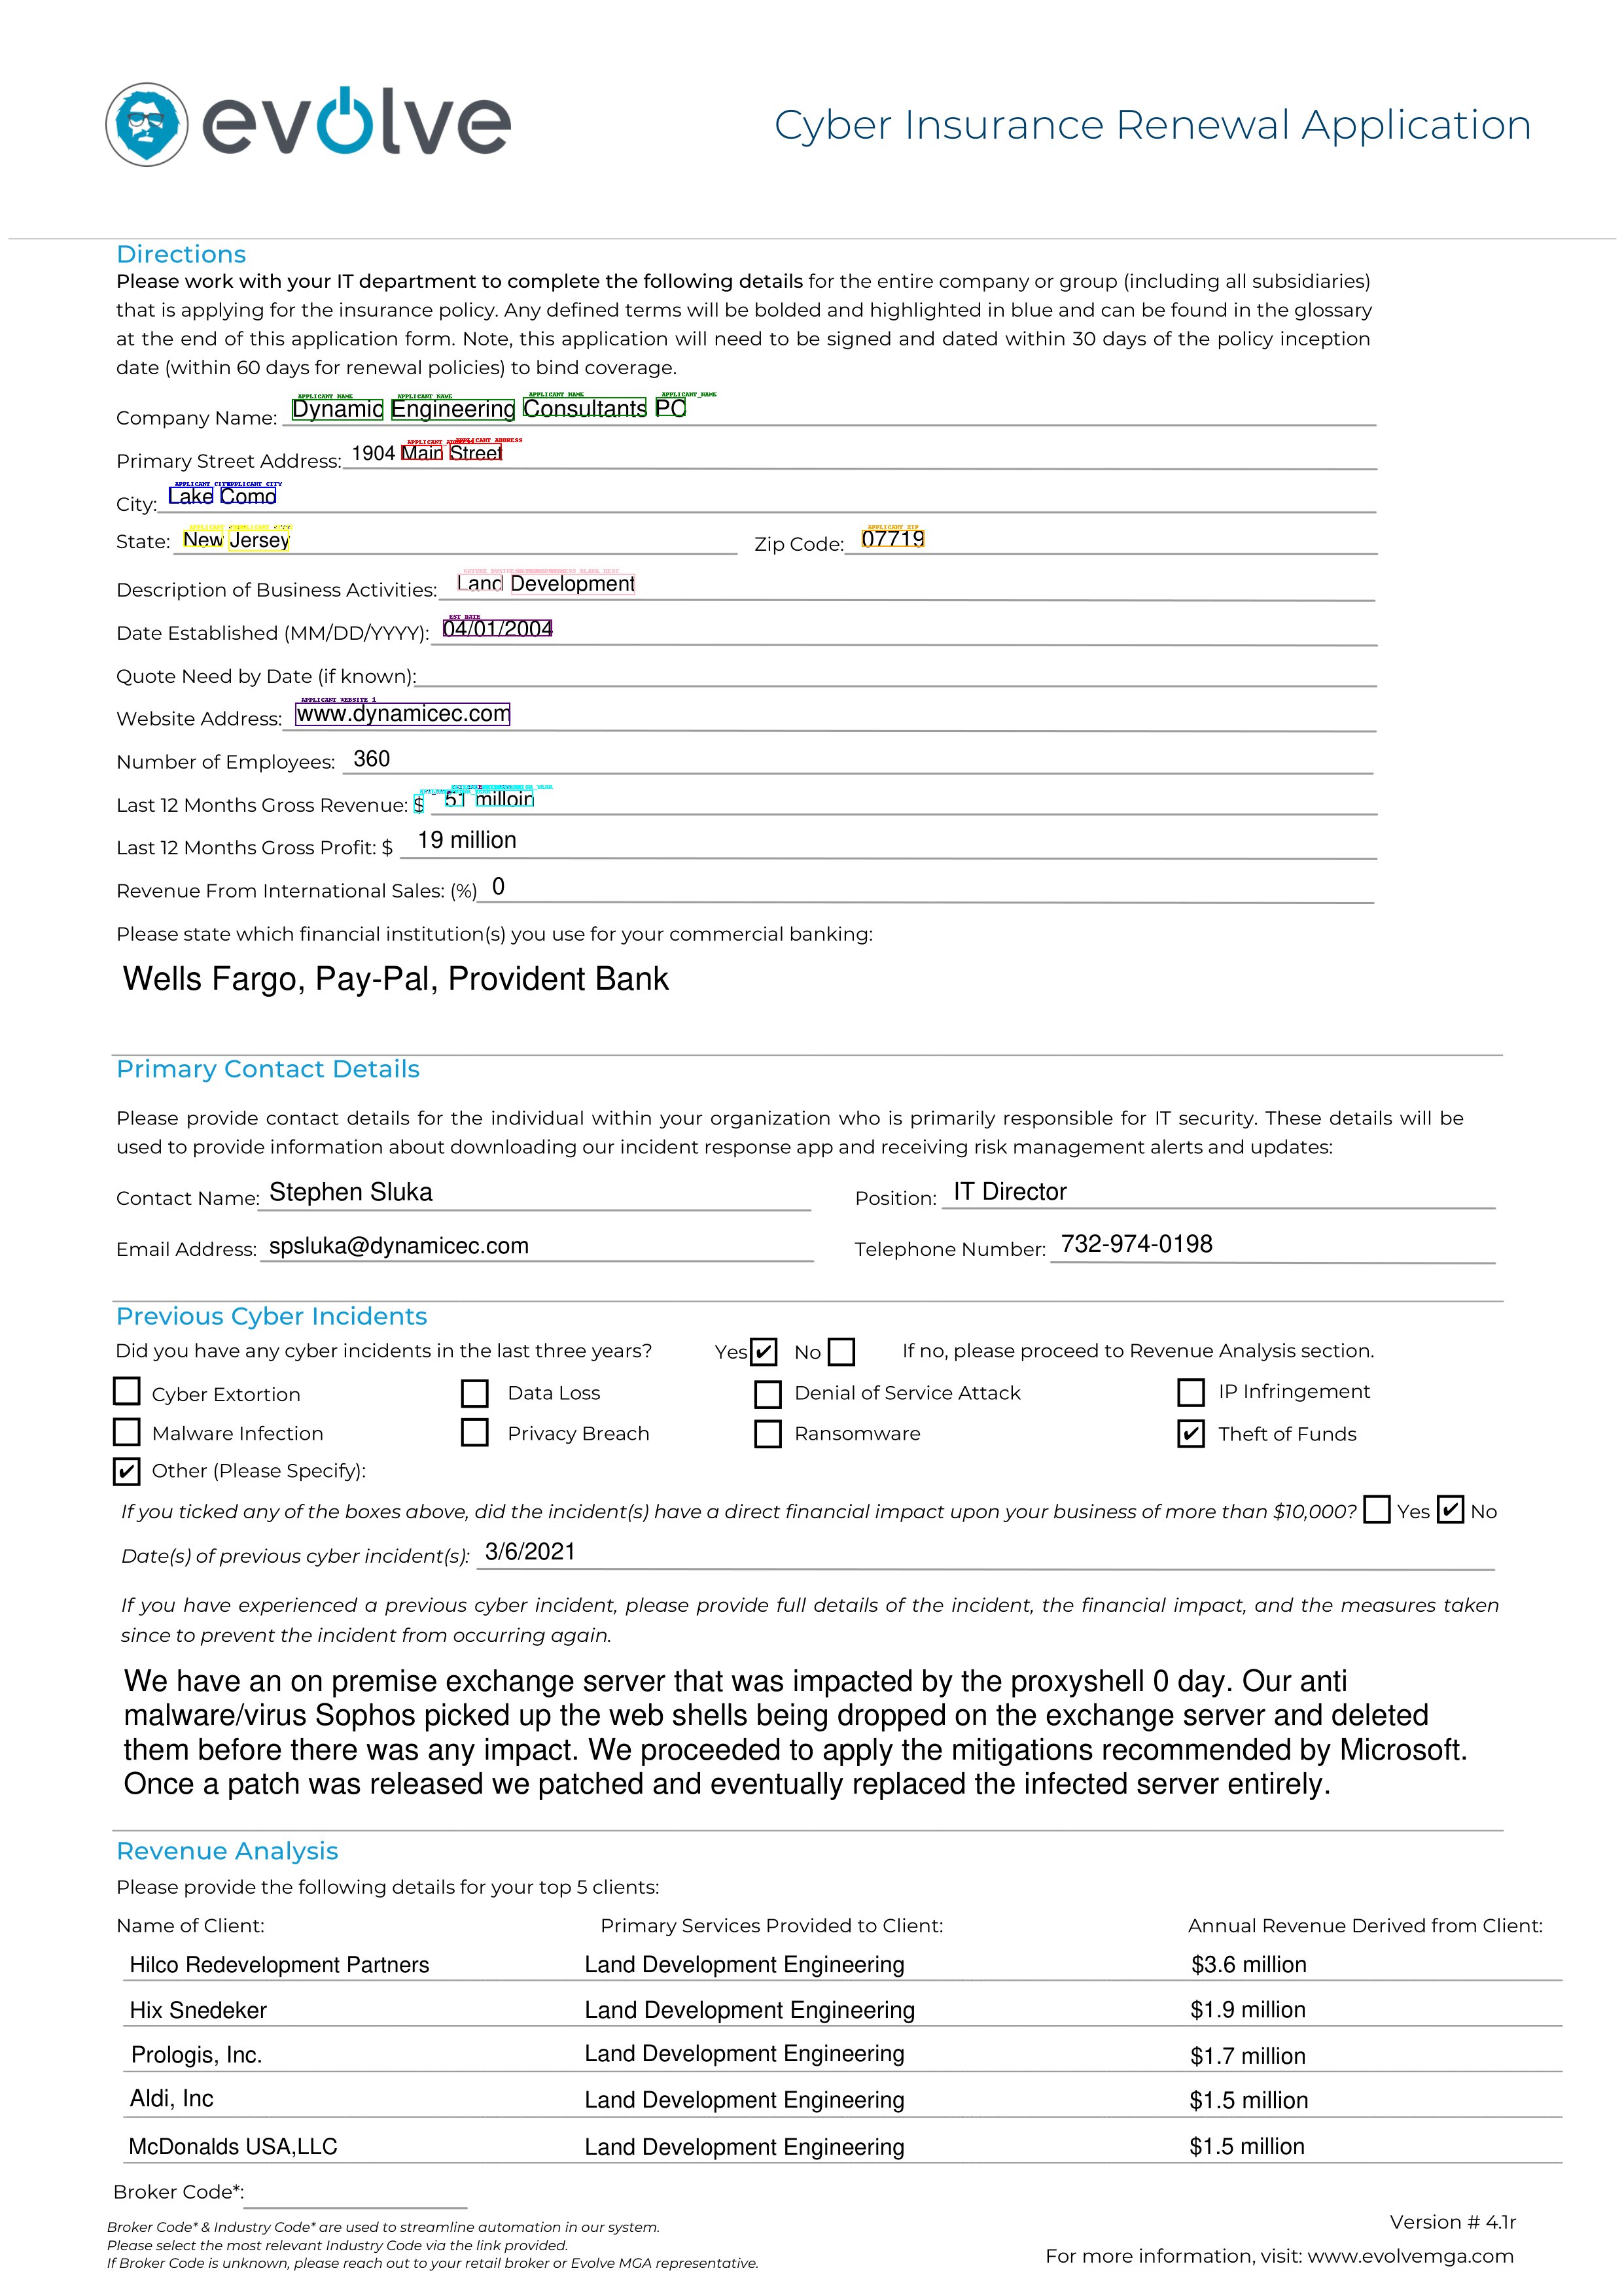

In [46]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label])
  print(f"{actual_label}: {word}")
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

json_data = {}

def create_json_data(key, val):
    if key in json_data:
      json_data[key] = json_data[key] + " " + val
    if key not in json_data:
      json_data[key] = val

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label])
  print(f"{actual_label}: {word}")
  create_json_data(label, word)
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

In [ ]:
print(json_data)